# ORIE 4580/5580/5581 Assignment 3

#### Students: A. Gordon (alg332)

### Github link: [Repository for ORIE5580](https://github.com/ariana-gordon/simulations5580)


### Instructions


* Due Thursday September 25, at 11.59pm on Gradescope.
* Assignment .ipynb files available for download on [Canvas](https://canvas.cornell.edu/courses/80773#:~:text=Assignments-,Assignments,-Assignments%20module%20publish).
* Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Gemini/Claude/ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**.
* You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.




### Suggested reading

Chapters 7 (you can skim through this), and chapters 8 and 9 of [Introduction to Probability](https://chance.dartmouth.edu/teaching_aids/books_articles/probability_book/book.html) by Grinstead and Snell.

Chapter 3 and chapter 4 (up to section 4.5) of [Simulation by Ross](https://catalog.library.cornell.edu/catalog/12745977).

In [154]:
#importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

<hr><hr>

## Question 1: Combining LCGs (20 points)

In order to avoid biases, simulations should not use anywhere near the full period of an LCG (otherwise, the random sequence repeats\ldots). For example, a typical traffic simulator may have $10,000$ vehicles, each experiencing thousands of random disturbances, thus needing around $10^7$ random samples per replication -- for this, an LCG using $m=2^{31}-1\approx 2\times 10^9$ is insufficient, as after $100$ replications the sequences get correlated.

One method to combine multiple LCGs to obtain a generator with a longer period is to add a smaller period LCG to it. For example, suppose we have two generators $X_{n+1}  =  (a_1 X_n) \mbox{ mod } m_1$ and $Y_{n+1}  =  (a_2 Y_n) \mbox{ mod } m_2$, with $m_1>m_2$. We can derive a combined generator by setting $Z_n  =  (X_n + Y_n) \mbox{ mod } m_1$. If properly designed, the resulting period can be on the order of $m_1m_2$. We will now study a small example to see how this works.


<hr>

**(a)** Consider two LCGs, $x_{n+1} = (5 x_n) \mod 16$ and $y_{n+1} = (2 y_n) \mod 7$. Starting both with seed $x_0 = y_0 = 1$, plot the sequences $x_n, y_n$ using the clock visualization introduced in class (separate plot for each sequence; you can use and modify the code in Demo-PRNGs.ipynb on Canvas).

<hr>

In [155]:
# Functions to visualize LCG sequence on clock (see demo notebook)

# All code is taken from the in-class demo notebook

# Make sure we have the packages we need
import numpy as np
from scipy import stats
import math

# Configuring matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.style.use('dark_background')
plt.rcParams["image.cmap"] = 'Set3'

# Choosing a colormap for the plot colors
cmap=plt.get_cmap('Set3')

def plot_clock_face(m, fig, annotate=False):
  """
  Plot points on a unit circle representing the LCG sequence on a clock face.

  Parameters:
  m (int): The modulus value for the LCG sequence.
  fig (matplotlib.figure.Figure): The figure object to draw on.
  annotate (bool): Whether to annotate points with their index.

  Returns:
  None
  """
  # Plot m points on the unit circle
  for i in range(m):
      theta = 2.0 * np.pi * i / m
      plt.plot(np.sin(theta), np.cos(theta), 'rs', markersize = 10)
      if annotate:
          plt.annotate(str(i), (np.pi/2 - theta, 1.05), xycoords='polar')

def plot_clock_path(m, x, fig, color='y'):
    """
    Plot the path of an LCG sequence on a clock face.

    Parameters:
    m (int): The modulus value for the LCG sequence.
    x (numpy.ndarray): The LCG sequence.
    fig (matplotlib.figure.Figure): The figure object to draw on.
    color (str): The color for the path.

    Returns:
    None
    """
    # Plot the seed node
    theta_0 = 2.0 * np.pi * (x[0] * (m + 1) - 1) / m
    plt.plot(np.sin(theta_0), np.cos(theta_0), 'gs', markersize = 10)

    # Plot the path of the LCG sequence
    for i in range(len(x) - 1):
        theta_start = 2.0 * np.pi * (x[i] * (m + 1) - 1) / m
        theta_end = 2.0 * np.pi * (x[i + 1] * (m + 1) - 1) / m
        x_start = np.sin(theta_start)
        y_start = np.cos(theta_start)
        del_x = np.sin(theta_end) - np.sin(theta_start)
        del_y = np.cos(theta_end) - np.cos(theta_start)
        if abs(del_x) > 0 or abs(del_y) > 0:
            plt.arrow(x_start, y_start, del_x, del_y,
                      length_includes_head=True, head_width=0.05, head_length=0.1, fc=color, ec=color)


In [156]:
# Function to generate pseudorandom sequence using LCG
# Set default parameters to glibc specifications (see demo notebook)

#Code taken from class demo notebook

def LCG(n, m=2**31-1, a=1103515245, c=12345, seed=1):
    """
    Generate a pseudorandom sequence using a Linear Congruential Generator (LCG).

    Parameters:
    n (int): The number of pseudorandom numbers to generate.
    m (int): The modulus value (default is 2^31-1, following glibc specifications).
    a (int): The multiplier value (default is 1103515245, following glibc specifications).
    c (int): The increment value (default is 12345, following glibc specifications).
    seed (int): The initial seed value (default is 1).

    Returns:
    numpy.ndarray: An array of pseudorandom numbers in the range [0, 1).
    """
    # Initialize an array to store the generated pseudorandom numbers
    output = np.zeros(n)

    x = seed
    for i in range(n):
        # Calculate the pseudorandom number and normalize it to [0, 1)
        output[i] = (x + 1.0) / (m + 1.0)

        # Update the LCG state using the specified parameters
        x = (a * x + c) % m

    return output

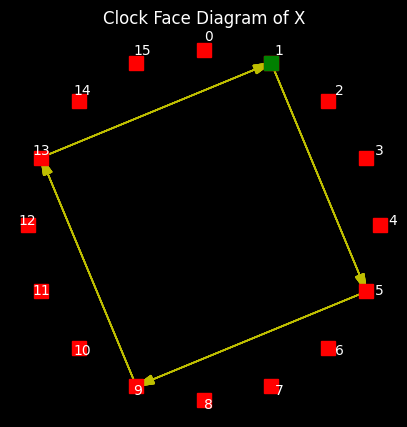

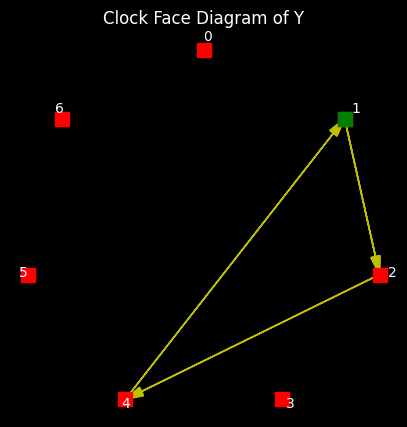

In [157]:
# Ans

#Begin by plotting x

m = 16
a = 5
c = 0

fig = plt.figure(figsize=(5,5))
x = LCG(n=m+1,m=m,a=a,c=c)

plot_clock_face(m,fig,annotate = True)
plot_clock_path(m,x,fig)
#plt.axis('equal')
plt.axis('off')
plt.title("Clock Face Diagram of X")
plt.show()

#Then plot Y

m = 7
a = 2
c = 0

fig = plt.figure(figsize=(5,5))
y = LCG(n=m+1,m=m,a=a,c=c)

plot_clock_face(m,fig,annotate = True)
plot_clock_path(m,y,fig)
#plt.axis('equal')
plt.axis('off')
plt.title("Clock Face Diagram of Y")
plt.show()

<hr>

**(b)** Next, define a combined LCG as $z_{n} = (x_n+y_n) \mod 16$. Starting both the base LCGs with seed $x_0 = y_0 = 1$, plot the sequence $z_n$ using the clock visualization given in class.

<hr>

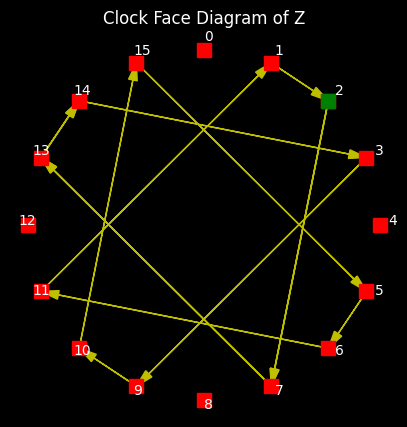

In [158]:
# we have already generated X and Y with periods 4 and 3 respectively
# zn should have a period of 12
x = x[:4]
y = y[:3]


m_x = 16
a_x = 5
m_y = 7
a_y = 2
m_z= 16
n_z = m_z+1

# Initialize an array to store the generated pseudorandom numbers
z_output = np.zeros(n_z)

#Begin by defining the seed
z = 2
for i in range(n_z):
    # Calculate the pseudorandom number and normalize it to [0, 1)
    z_output[i] = (z + 1.0) / (m_z + 1.0)

    # Update the LCG state using the specified parameters
    #turn x and y back into integers
    x_i = (x[i %len(x)] * (m_x + 1) - 1)
    y_i = (y[i %len(y)] * (m_y + 1) - 1)
    z = (x_i+y_i) % m_z


# --- now plot ---
fig = plt.figure(figsize=(5,5))

plot_clock_face(m_z, fig, annotate=True)
plot_clock_path(m_z, z_output, fig)

plt.axis('off')
plt.title("Clock Face Diagram of Z")
plt.show()


___
**(c)** What are the periods of the pseudo-random sequences $x_n, y_n$ and $z_n$?
___

### Ans.

The period of $x_n$ is 4. The period of $y_n$ is 3. The period of $z_n$ is 12.


___
___
## Question 2: inverting cdfs (25 pts)

In class, we defined $F^{-1}(y)$ for a continuous increasing cdf $F(x)$ as the unique $x$ such that $F(x) = y$ (for $y\in[0,1]$). More generally, for any cdf $F$ we can use the inversion method based on its generalized inverse or *pseudoinverse*:
	$$F^{-1}(y) = \inf\{x|F(x)\geq y\}$$
	(where $\inf$ denotes the \href{https://en.wikipedia.org/wiki/Infimum_and_supremum}{infimum}; if you have not seen this before, treat it as minimum).


___
**(a)** Find the pseudoinverse $F^{-1}(y)$ for the following mixed (discrete/continuous) cdf
	$$F(x)=
	\begin{cases}
	0 & \mbox{for $x < 0$}\\
	x & \mbox{for $0 \leq x < \frac{1}{2}$}, \\
	\frac{1}{2} & \mbox{for $\frac{1}{2}\leq x < 1$}, \\
	1 & \mbox{for $x\geq 1$}
	 \end{cases}$$
___



### Ans.

$$F^{-1}(y)=
	\begin{cases}
	y & \mbox{for $0 \leq y \leq \frac{1}{2}$}, \\
	1 & \mbox{for $1/2 < y \leq 1$}
	 \end{cases}$$

$y \in [0,1]$

___
**(b)** Use the above definition to get an inversion algorithm for the $Geometric(p)$ distribution (with pmf $p(k) = p(1-p)^{k-1}\,\forall\,k\in\{1,2,3,\ldots\}$). Implement this, and generate and plot the histogram of 1000 samples from a $Geometric(0.42)$ distribution.
(For this, it may be useful for you to first understand how the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) library works, and in particular, how it provides methods to compute various statistics for many different random variables, including the [geometric r.v.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.geom.html#scipy.stats.geom))
___

$F_X(k) = P(X \le k) = 1 - (1-p)^k$

Solve for k

$y+1 = (1-p)^k$

$ln(y+1) = kln(1-p)$

$k = \frac{ln(y+1)}{ln(1-p)}$

However, k needs to be an integer due to the discrete nature of the geometric distribution. Take the ceiling, which gives the smallest integer k for which F(k) > y.

$F_X^{-1}(y) = \left\lceil \frac{\log(1 - y)}{\log(1 - p)} \right\rceil, \quad 0 < y < 1$

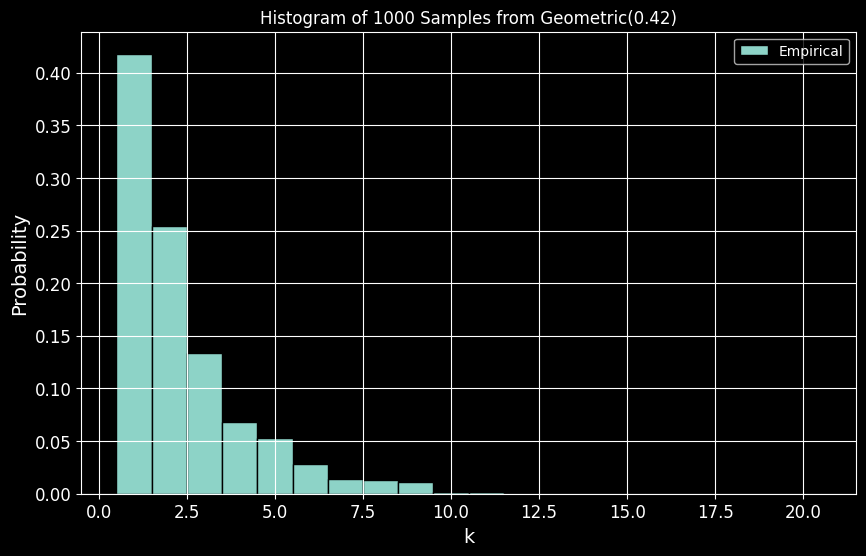

In [159]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
p = 0.42
n_samples = 1000

# Inversion method for Geometric(p)
U = np.random.uniform(0, 1, size=n_samples)
samples = np.ceil(np.log(1 - U) / np.log(1 - p)).astype(int)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=np.arange(1, max(samples)+2) - 0.5, edgecolor='black', density=True, label='Empirical')
plt.title(f'Histogram of 1000 Samples from Geometric({p})')
plt.xlabel('k')
plt.ylabel('Probability')
plt.grid(True)


plt.legend()
plt.grid(True)
plt.show()

___
**(c)** The p.d.f. of the random variable $X$ is given by
	$$
	f(x) =
	\begin{cases}
		e^{x-2} & \text{for }0 \leq x \leq 2, \\
		e^{-x} & \text{for }x > 2, \\
		0 & \text{otherwise,}
	\end{cases}
	$$
	Describe and implement an inversion algorithm to generate samples of $X$. Generate 1,000 samples and plot a histogram. Compare the histogram and the p.d.f.


___

### Ans.
The CDF, F(x) is given by the following:

$$
	F(x) =
	\begin{cases}
    0 & x <0 \\
		e^{-2}(e^x -1) & \text{for }0 \leq x \leq 2, \\
		1- e^{-x} & \text{for }x > 2, \\
	\end{cases}
	$$
The inverse of the CDF is the following:

$$
	F^{-1}(y) =
	\begin{cases}
		ln(1+ye^2) & \text{for }0 \leq y \leq 1-e^{-2}, \\
		-ln(1-y) & \text{for } 1-e^{-2} <y <1, \\
	\end{cases}
	$$


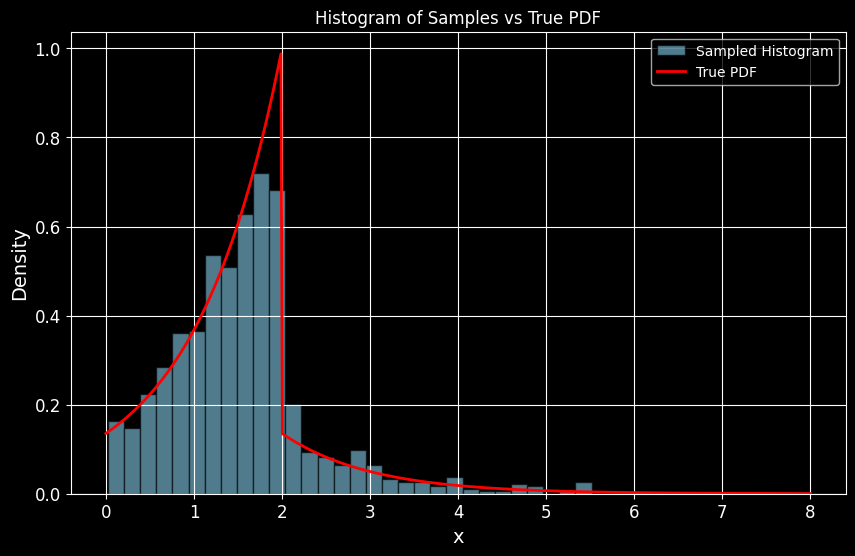

In [160]:
threshold = 1 - np.exp(-2)  # Define where the function changes
e2 = np.exp(2)

# Inversion sampling function
def sample_X(n):
    #define a uniform sample
    U = np.random.uniform(0, 1, n)
    X = np.where(U <= threshold,
                 np.log(1 + U * e2),
                 -np.log(1 - U))
    return X

# Generate 1000 samples
samples = sample_X(1000)

# Plot histogram
x_vals = np.linspace(0, 8, 500)
pdf_vals = np.piecewise(x_vals,
                        [x_vals <= 2, x_vals > 2],
                        [lambda x: np.exp(x - 2), lambda x: np.exp(-x)])

plt.figure(figsize=(10, 6))
plt.hist(samples, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='k', label='Sampled Histogram')
plt.plot(x_vals, pdf_vals, 'r-', lw=2, label='True PDF')
plt.title('Histogram of Samples vs True PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

<hr><hr>

## Question 3: Acceptance-Rejection (25 pts)

Let the random variable $X$ have density
$$f(x) = \begin{cases} (5 x^4 + 4x^3 + 3x^2+1)/4  & \text{ for } 0 \leq x \leq 1, \\
0 & \text{ otherwise. } \end{cases}$$

<hr>

**(a)** Give an acceptance-rejection algorithm to generate samples of
	$X$.

<hr>

### Ans.


Begin by finding a number that f(x) will not exceed over its domain. Since f(x) is increasing over [0,1], it will attain its maximum at x = 1. Therefore its maximum is (5+4+3+1)/4 or 13/4. Choose M = 16/4 or 4 so that the function will never exceed M.

In [161]:
#Set value of M

M = 4

def f(x):
  return (5*x**4 + 4*x**3 + 3*x**2+1)/4
#Say you want 1000 valid samples
desired_samples = 1000
samples = []
while len(samples) < desired_samples:
  #Step 1: Generate a uniform rv over the domain [0,1]
  U = np.random.uniform(0, 1)
  #Step 2: Generate a uniform rv over the range [0,M]
  V = np.random.uniform(0,M)

#Step 3: Accept if V<=F(U)
  if V <= f(U):
    samples.append(U)



<hr>

**(b)** On average, how many samples from the uniform distribution over $[0, 1]$ would your acceptance-rejection algorithm need in order to generate one sample of $X$?

<hr>

### Ans.
The probability that a sample will be accepted will follow the geometric distribution. To find the expectation of such an RV, one needs to find the probability of success, i.e:

$P(V<=f(U))$

Use the law of total probability

$P(V<=f(U)) = \int_0^1 P(V \leq f(U) | U =u) P(U=u) \, du$

This is the CDF/PDF of the uniform.

$ = \int_0^1 \frac{f(u)-0}{M-0}*\frac{1}{1-0} du$

$ = \frac{1}{M} \int_0^1 (5 u^4 + 4u^3 + 3u^2+1)/4  \, du = \frac{1}{M}$

I set M = 4, therefore the probability of the AR algorithm accepting the sample is $\frac{1}{4}$.

Now, use the formula for the expected value of a geometric distribution.

$E[X] = \frac{1}{p}$

The expected number of samples is M (or in this case, 4). However, there are two uniforms per sample, so the final number is 2M or 8.


<hr>

**(c)** Use your algorithm in (a) to generate 2,500 samples of $X$. Note that this will require more than 2500 uniform random variables.

Plot a histogram of your sample   and compare it against the true pdf.

<hr>

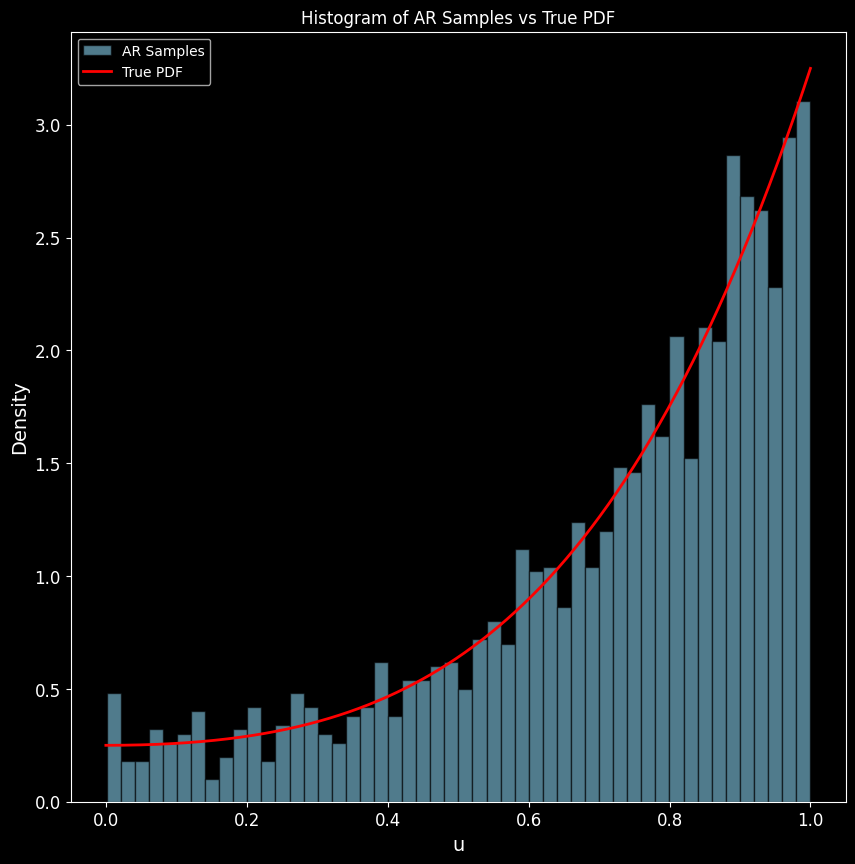

In [162]:
#Say you want 1000 valid samples
desired_samples = 2500
samples = []
while len(samples) < desired_samples:
  #Step 1: Generate a uniform rv over the domain [0,1]
  U = np.random.uniform(0, 1)
  #Step 2: Generate a uniform rv over the range [0,M]
  V = np.random.uniform(0,M)

#Step 3: Accept if V<=F(U)
  if V <= f(U):
    samples.append(U)

plt.hist(samples, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='AR Samples')


u_vals = np.linspace(0,1,500)
pdf_vals = f(u_vals)

plt.plot(u_vals, pdf_vals, 'r-', lw=2, label='True PDF')

# -----------------------
# 4. Labels and legend
# -----------------------
plt.title("Histogram of AR Samples vs True PDF")
plt.xlabel("u")
plt.ylabel("Density")
plt.legend()

<hr><hr>

## Question 4: Generalized Acceptance-Rejection (30 pts)

We want to generate a $\mathcal{N}(0,1)$ rv $X$, with pdf
$f(x) = \frac{e^{-x^2/2}}{\sqrt{2\pi}} $,
using generalized acceptance-rejection.

<hr>

**(a)** First, suppose we choose the proposal distribution to be a \emph{Laplace}(i.e., two-sided Exponential) distribution, which has pdf $g(x) = e^{-|x|}/2$. Describe (and implement) an inversion algorithm to get samples from this distribution.

<hr>

Begin by determining the inverse distribution.
Let $$ g(x) =
\begin{cases} e^{-x}/2 & \text{ for } x\leq0, \\
e^{x}/2 & \text{ for }  x>0\end{cases}$$

The CDF is the following:
$$ G(x) =
\begin{cases} e^{x}/2 & \text{ for } x\leq0, \\
1- e^{-x}/2 & \text{ for }  x>0\end{cases}$$

The inverse CDF is the following:
$$ G^{-1}(y) =
\begin{cases} ln(2y) & \text{ for } y \leq \frac{1}{2}, \\
-ln(2-2y) & \text{ for }  y>\frac{1}{2}\end{cases}$$

In [163]:
def sample_laplace():
    U = np.random.uniform(0, 1)
    if U < 0.5:
        return np.log(2 * U)
    else:
        return -np.log(2 * (1 - U))


<hr>

**(b)** Determine the smallest $k$ such that $kg(x)\geq f(x)\,\forall\,x\in\mathbb{R}$. Using this, propose (and implement) an acceptance-rejection algorithm for sampling $X\sim\mathcal{N}(0,1)$, and compute the expected number of samples needed for generating each sample.

<hr>

### Ans.
For the above relation to be true
$k \geq \frac{f(x)}{g(x)} = \frac{2}{\sqrt{2\pi}}e^{-x^2/2 + |x|}$

Find the maximum of the function:
$h(x) = e^{-x^2/2 + |x|}$

The derivative is the following

for $x>0$:$-(x-1)*e^{x-x^2/2}$

for $x \leq 0$: $-(x+1)*e^{x-x^2/2}$

The maximum/minimum are attained at 1 and -1.

$h(1)= h(-1) = e^{\frac{1}{2}}$

Therefore $k \geq \frac{2}{\sqrt{2\pi}}e^{\frac{1}{2}}$

As for the expected value:

You accept the sample if U $\sim Uniform(0,1)$

$ u \leq \frac{f(x)}{kg(x)}$

Therefore, the probability that a sample is accepted is (because x,y indep)

$p
= \int \frac{f(x)}{k g(x)} g(x)\, dx
= \frac{1}{k} \int f(x)\, dx
= \frac{1}{k} $

Since, the number of samples follows a geometric distribution with p = 1/k, then,

$E[\text{number of samples}] = \frac{1}{\frac{1}{k}} = k$


<hr>

**(c)** Generate $1000$ samples from your method in part (b), and plot the histogram of the samples. Also report the average and 95\% CI for the number of $U[0,1]$ samples needed to generate the $1000$ samples.

<hr>

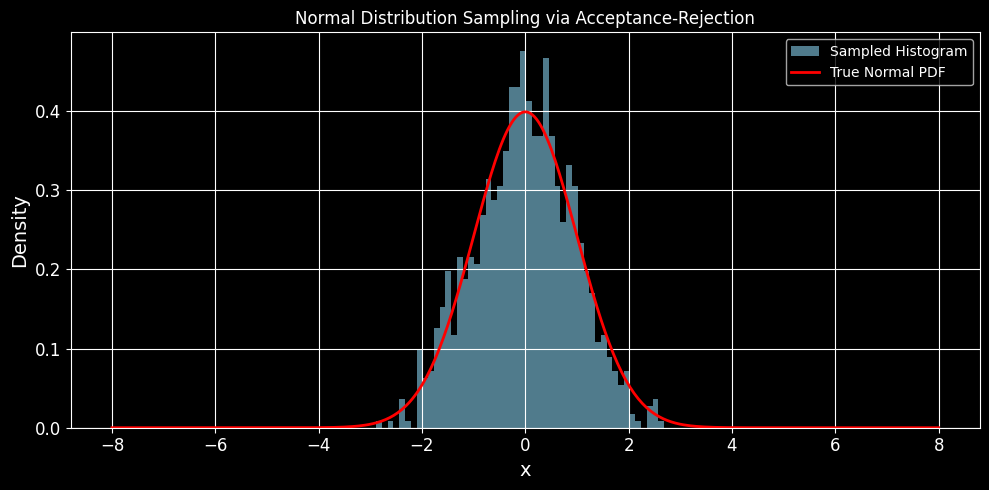

The Average Number of Samples is: 2.5534465534465536
95% CI: (2.4774, 2.6295)
1.315489246958914


In [167]:
k = 2/np.sqrt(2*np.pi)*np.exp(0.5)

n_samples = 1000

samples = []
uniform_counts = [0]  # Track how many U[0,1] samples were used per accepted sample

def f(x):
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
def g(x):
    return np.exp(-abs(x))/2

uniform_count = 0
while len(samples) < n_samples:
    U = np.random.uniform(0, 1)
    x = sample_laplace()
    uniform_count +=2
    if U <= f(x)/(k*g(x)):
        samples.append(x)
        uniform_counts.append(uniform_count) #reset the counter
        uniform_count = 0




plt.figure(figsize=(10, 5))
plt.hist(samples, bins=50, density=True, alpha=0.6, color='skyblue', label='Sampled Histogram')

# Overlay true Normal PDF
x = np.linspace(-8, 8, 400)
pdf = f(x)
plt.plot(x, pdf, 'r', lw=2, label='True Normal PDF')

# Add labels and legend
plt.title("Normal Distribution Sampling via Acceptance-Rejection")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Calculate the Average and 95% CI for the uniform samples:
mean = np.mean(uniform_counts)
ci = 1.96*np.std(uniform_counts)/np.sqrt(n_samples)

lower_bound = mean - ci
upper_bound = mean + ci
print("The Average Number of Samples is:", mean)
print(f"95% CI: ({lower_bound:.4f}, {upper_bound:.4f})")


<hr>

**(d)** Now, suppose instead we choose the proposal distribution to be a Cauchy  distribution with pdf $g(x) = \frac{1}{\pi(1+x^2)}$. Describe and implement an inversion algorithm to get samples from this distribution, and plot the histogram of 1000 samples from this distribution.

<hr>

Start by finding the CDF, G(x)

$G(x) =\frac{ arctan(x)}{\pi} + 0.5$

The inverse of which is the following:

$G^{-1}(y) =tan(\pi*(y-0.5))$


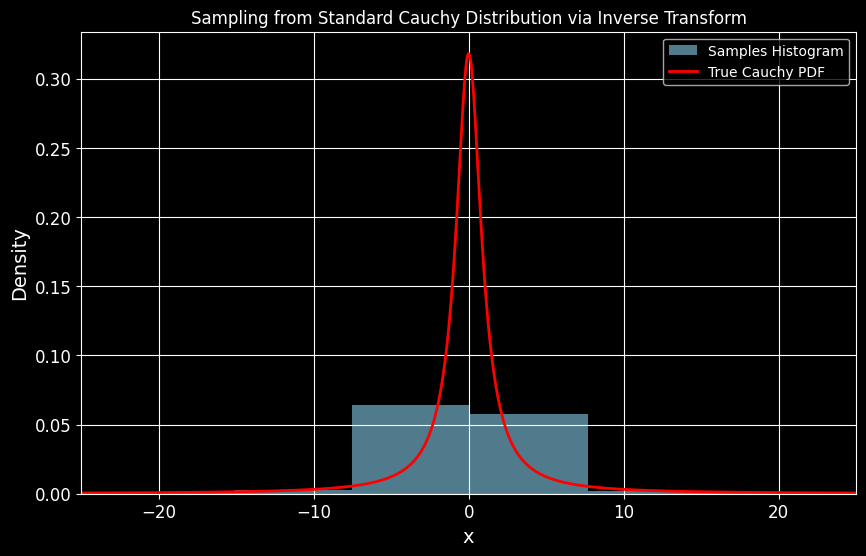

In [165]:
def sample_cauchy(n):
    U = np.random.uniform(0, 1, size=n)
    X = np.tan(np.pi * (U - 0.5))
    return X

def cauchy_pdf(x):
    return 1 / (np.pi * (1 + x**2))

# Generate samples
samples = sample_cauchy(1000)

plt.figure(figsize=(10, 6))
plt.hist(samples, bins=1000, density=True, alpha=0.6, color='skyblue', label='Samples Histogram')

# Plot true PDF on a wider x range (to ensure smooth curve)
x = np.linspace(-25, 25, 1000)
plt.plot(x, cauchy_pdf(x), 'r-', lw=2, label='True Cauchy PDF')

# Set x-axis limits to [-5, 5]
plt.xlim(-25, 25)

plt.title('Sampling from Standard Cauchy Distribution via Inverse Transform')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()





**(e)** Repeat parts $(b)$ and $(c)$ for this proposal distribution.

<hr>

### Ans.

Find k.

$k \geq \frac{f(x)}{g(x)} = \frac{e^{-x^2/2}}{\sqrt{2\pi}}*\pi(1+x^2)$

Find the maximum of that function $h(x) = \frac{f(x)}{g(x)}$

$h'(x) = \frac{\pi}{\sqrt{2\pi}}e^{-x^2/2}(x-x^3) = 0$

The roots are -1, 0,1. The maxima can be found at 1,-1. Therefore,

$ k = \frac{2\pi}{\sqrt{2\pi}}*e^{-1/2} $

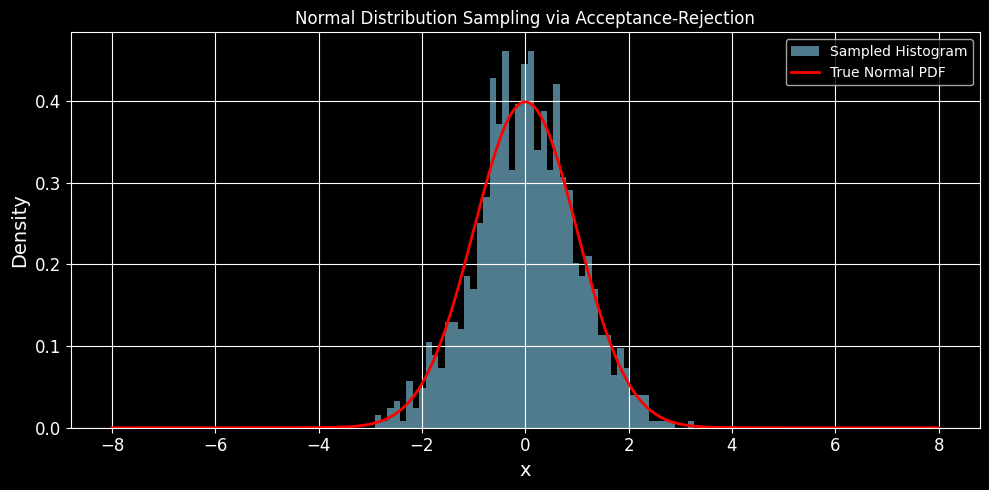

The Average Number of Samples is: 3.0489510489510487
95% CI: (2.9408, 3.1571)
1.520346901066281


In [168]:

k = (2*np.pi)/np.sqrt(2*np.pi)*np.exp(-0.5)

n_samples = 1000

samples = []
uniform_counts = [0]  # Track how many U[0,1] samples were used per accepted sample


uniform_count = 0
while len(samples) < n_samples:
    U = np.random.uniform(0, 1)
    x = sample_cauchy(1).item()
    uniform_count +=2
    if U <= f(x)/(k*cauchy_pdf(x)):
        samples.append(x)
        uniform_counts.append(uniform_count) #reset the counter
        uniform_count = 0

plt.figure(figsize=(10, 5))
plt.hist(samples, bins=50, density=True, alpha=0.6, color='skyblue', label='Sampled Histogram')

# Overlay true Normal PDF
x = np.linspace(-8, 8, 400)
pdf = f(x)
plt.plot(x, pdf, 'r', lw=2, label='True Normal PDF')

# Add labels and legend
plt.title("Normal Distribution Sampling via Acceptance-Rejection")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Calculate the Average and 95% CI for the uniform samples:
mean = np.mean(uniform_counts)
ci = 1.96*np.std(uniform_counts)/np.sqrt(n_samples)

lower_bound = mean - ci
upper_bound = mean + ci
print("The Average Number of Samples is:", mean)
print(f"95% CI: ({lower_bound:.4f}, {upper_bound:.4f})")